# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.560300,True,4.779165
1,-1.237910,False,-0.485195
2,-1.809642,False,-0.796393
3,-2.480514,False,0.529577
4,-0.593813,False,-2.753180
...,...,...,...
995,1.244544,True,5.381513
996,-0.969686,True,3.604713
997,-2.873670,False,-1.735903
998,-0.368460,False,-0.544818


<Axes: xlabel='v0'>

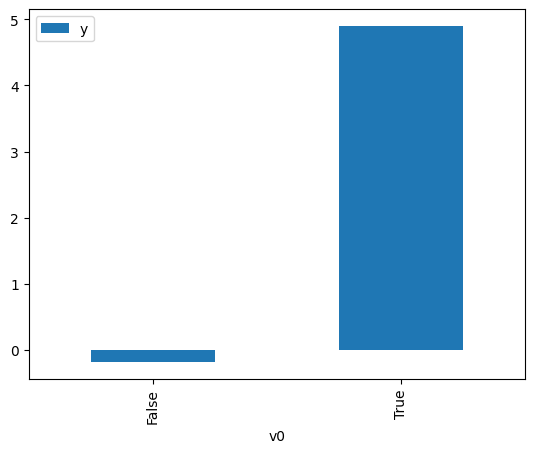

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

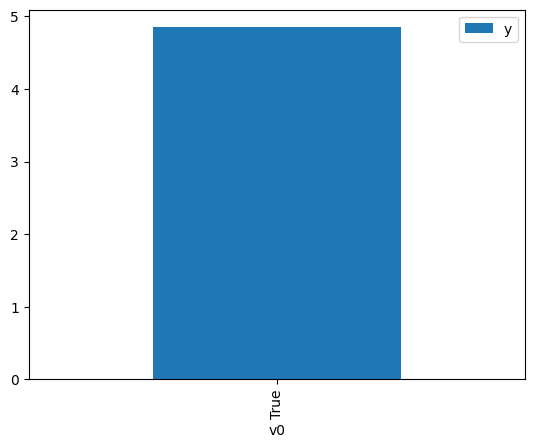

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.488223,False,-1.828713,0.916979,1.090538
1,0.112953,False,-0.671178,0.454670,2.199398
2,-0.429714,False,0.898786,0.666829,1.499634
3,-0.088602,False,-0.646487,0.535796,1.866383
4,0.291816,False,0.187732,0.384510,2.600714
...,...,...,...,...,...
995,-2.533603,False,-3.021821,0.983519,1.016757
996,-1.426028,False,-1.901157,0.909012,1.100096
997,-0.348504,False,0.005934,0.637107,1.569594
998,-2.241211,False,0.898483,0.973842,1.026861


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.768827,True,5.184682,0.224244,4.459431
1,0.027036,True,5.839323,0.510792,1.957743
2,0.939621,True,7.304068,0.819921,1.219630
3,0.343768,True,4.945160,0.635129,1.574483
4,-1.455279,True,4.464900,0.087159,11.473281
...,...,...,...,...,...
995,0.427481,True,6.294475,0.665827,1.501891
996,-0.056583,True,4.584881,0.477076,2.096102
997,-0.980441,True,3.750785,0.170430,5.867520
998,-2.032568,True,3.498436,0.036250,27.586331


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.897
Method:                 Least Squares   F-statistic:                              4365.
Date:                Tue, 28 Oct 2025   Prob (F-statistic):                        0.00
Time:                        05:44:53   Log-Likelihood:                         -1428.9
No. Observations:                1000   AIC:                                      2862.
Df Residuals:                     998   BIC:                                      2872.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2391      0.027      8.809      0.000       0.186       0.292
x2             5.0522      0.055     91.955      0.000       4.944       5.160
==============================================================================
Omnibus:                        0.197   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.906   Jarque-Bera (JB):                0.186
Skew:                          -0.033   Prob(JB):                        0.911
Kurtosis:                       2.997   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""